In [1]:
!pip install earthpy 

     |████████████████████████████████| 1.4 MB 7.0 MB/s 
     |████████████████████████████████| 1.0 MB 34.8 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 16.7 MB 39.1 MB/s 
     |████████████████████████████████| 6.3 MB 51.3 MB/s 


In [15]:
import os
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
from PIL import Image
import cv2

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
S_sentinel_bands = glob("/content/drive/MyDrive/Satellite_data/*B?*.tiff")
S_sentinel_bands.sort()
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))
    
arr_st = np.stack(l)

In [19]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 954
Width: 298
Bands: 12


In [20]:
S_sentinel_pan=glob("/content/drive/MyDrive/Satellite_data/*A?*.tiff")
S_sentinel_pan.sort()
l=[]
for i in S_sentinel_pan:
  with rio.open(i,"r") as f:
    l.append(f.read(1))

pan_stacks=np.stack(l)

In [21]:
print(f'Height: {pan_stacks.shape[1]}\nWidth: {pan_stacks.shape[2]}\nBands: {pan_stacks.shape[0]}')

Height: 954
Width: 298
Bands: 15


visualize MS bands

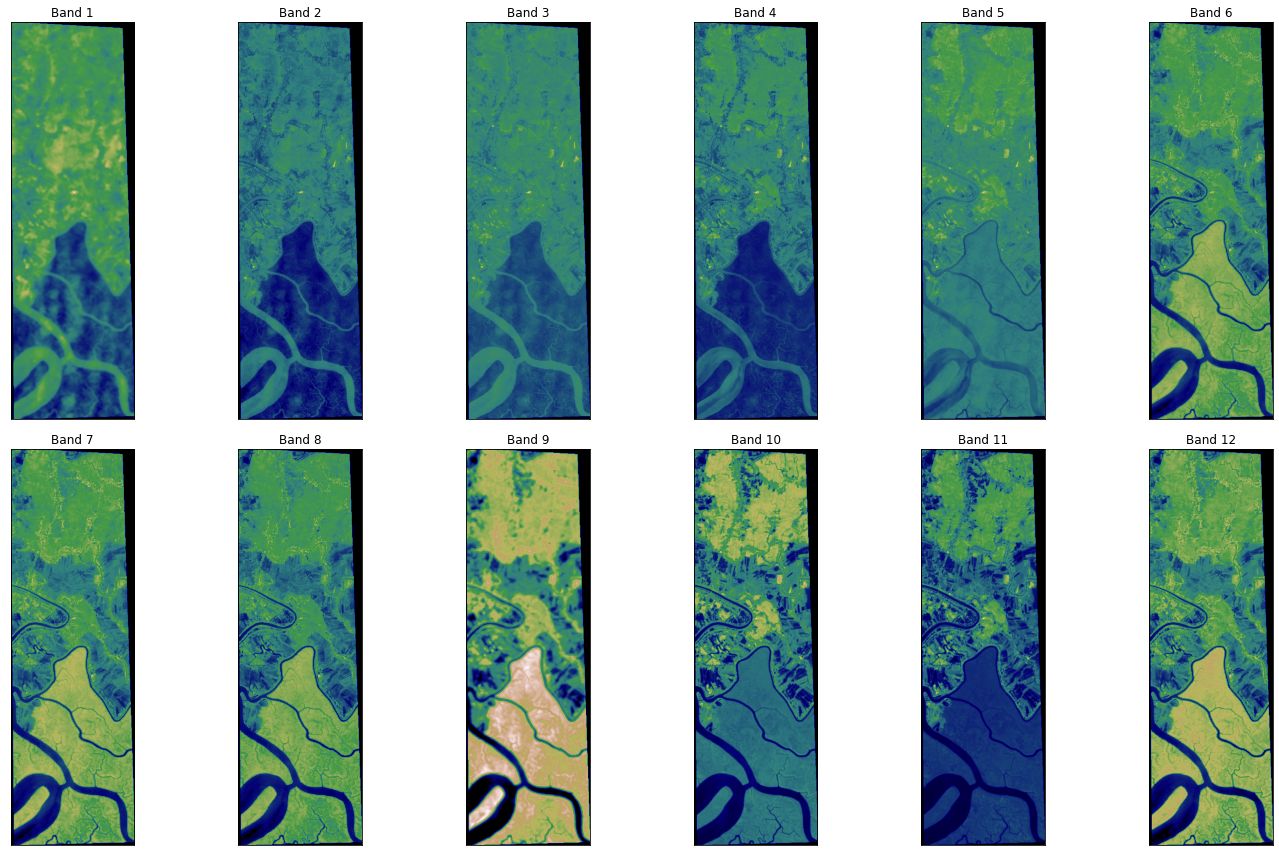

In [22]:
ep.plot_bands(arr_st, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

visualize PAN images

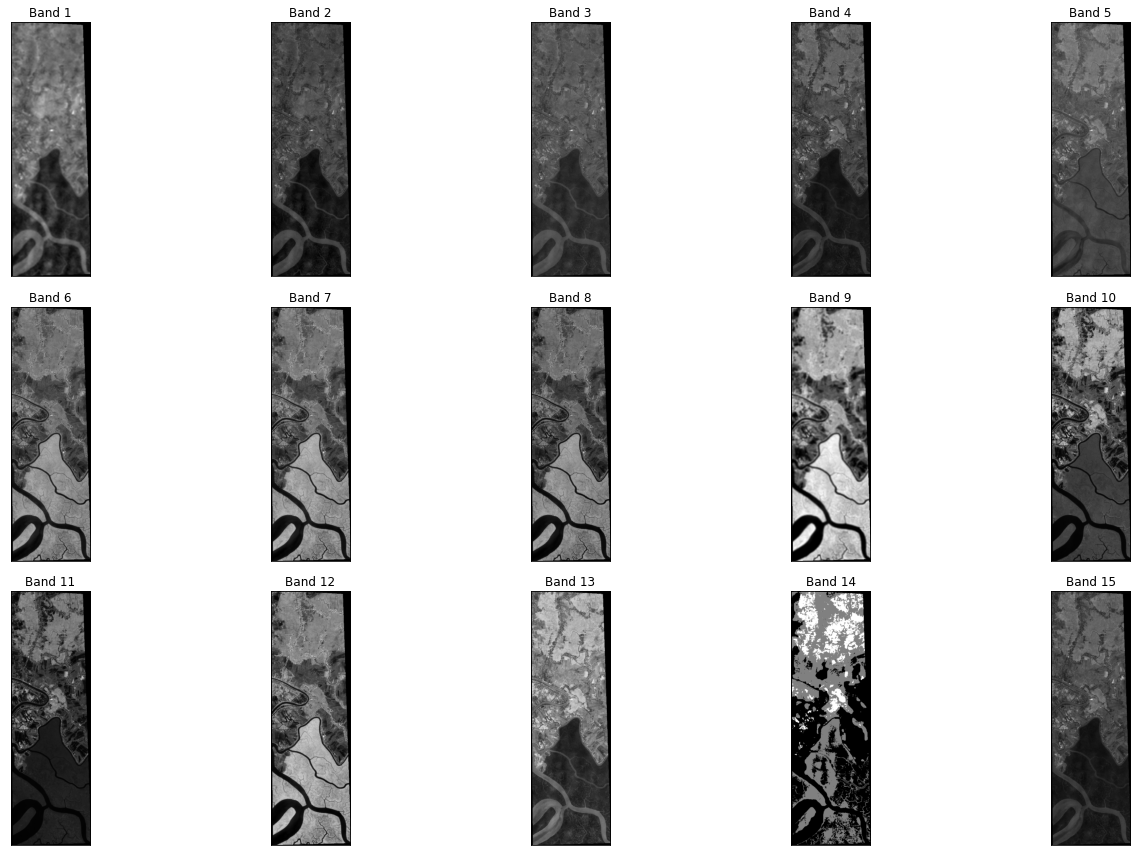

In [23]:
ep.plot_bands(pan_stacks, 
              cmap = 'gray', 
              figsize = (20, 12), 
              cols = 5, 
              cbar = False)
plt.show()

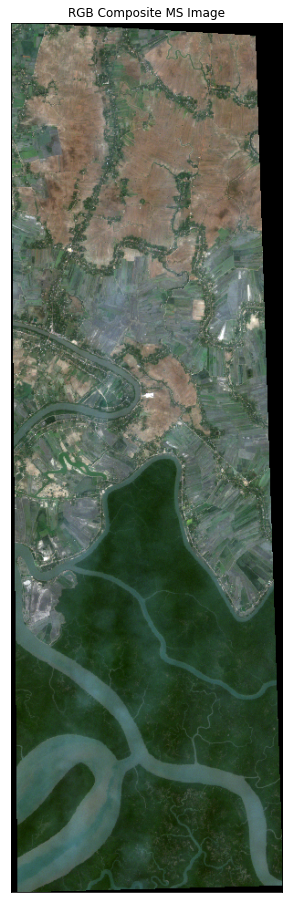

In [24]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  stretch=True,
                  str_clip=0.02,
                  figsize=(12, 16), 
                  title='RGB Composite MS Image'
                  )

plt.show()

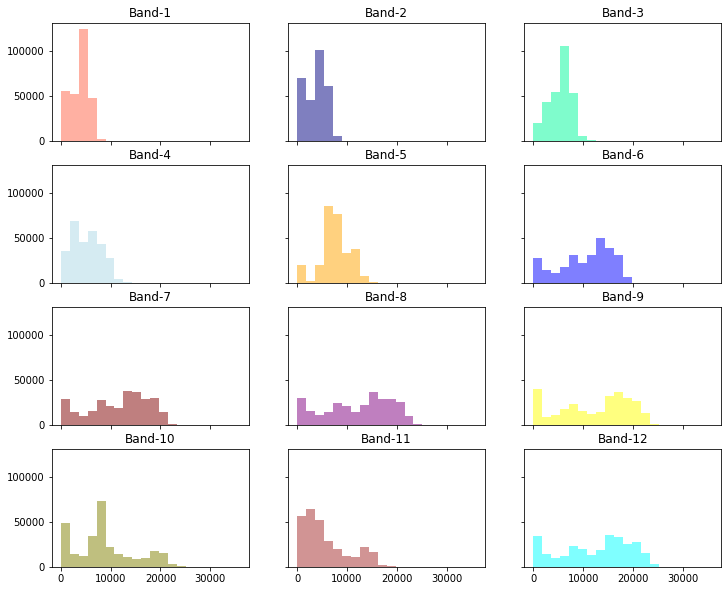

In [25]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10))

plt.show()

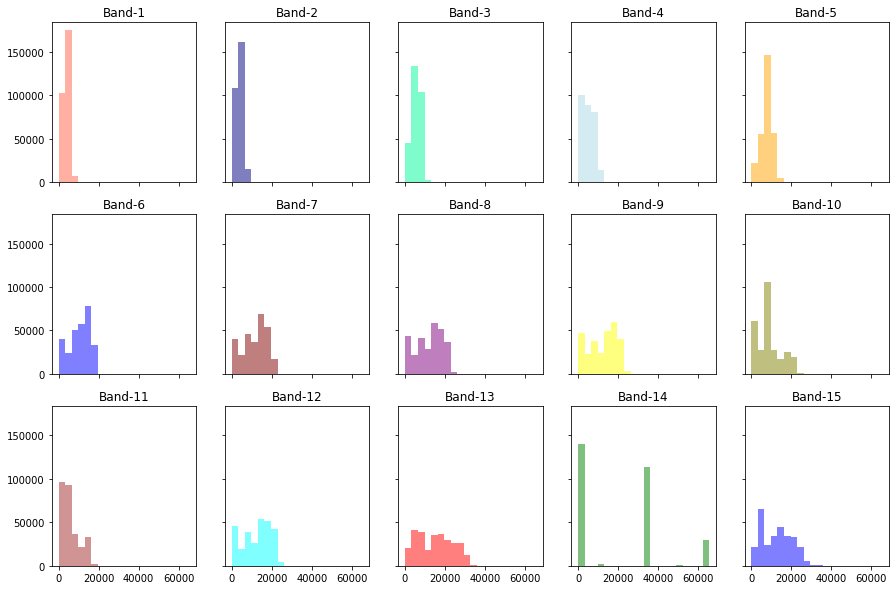

In [26]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan','red','green','blue']

ep.hist(pan_stacks, 
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 16)], 
        cols=5, 
        alpha=0.5, 
        figsize = (15, 10))

plt.show()

preprocessing of PCA 

In [27]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(954, 298, 12)

In [28]:
x.reshape(-1, 12).shape, 954*298

((284292, 12), 284292)

In [29]:
from sklearn.preprocessing import StandardScaler
X_data = x.reshape(-1, 12)
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)
X_scaled.shape

(284292, 12)

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
pca.fit(X_scaled)
data = pca.transform(X_scaled)

In [31]:
data.shape

(284292, 4)

In [32]:
pca.explained_variance_ratio_

array([0.55778198, 0.37521242, 0.0484222 , 0.00637526])

In [33]:
np.sum(pca.explained_variance_ratio_)

0.9877918653349009

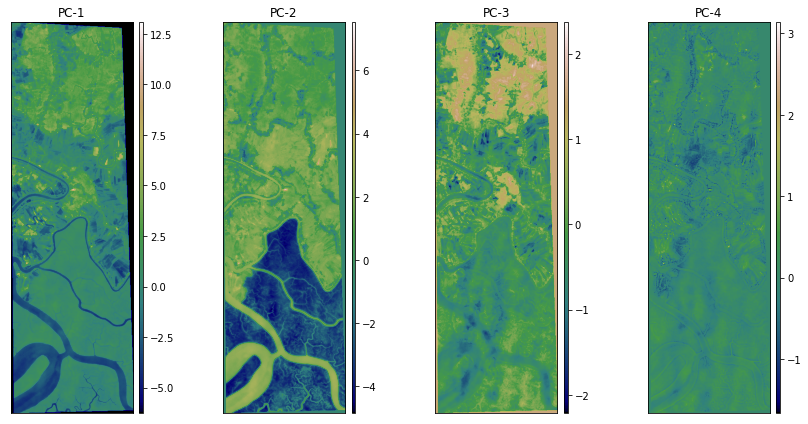

In [34]:
ep.plot_bands(np.moveaxis(data.reshape((954, 298, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 4,
              figsize = (12, 6),
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

morphological hat transformation on PAN

In [35]:
import cv2 as cv


In [36]:
kernel = np.ones((1,1),np.uint8)
pan_img=cv.imread("/content/drive/MyDrive/Satellite_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_True_color.tiff")
pan_gray=cv.cvtColor(pan_img,cv.COLOR_BGR2GRAY)
(thresh, im_bw) = cv.threshold(pan_gray, 2, 20, cv.THRESH_BINARY | cv.THRESH_OTSU)
thresh = 1
im_bw = cv.threshold(pan_gray, thresh, 255, cv.THRESH_BINARY)[1]
erosion = cv.erode(pan_gray,kernel,iterations = 1)


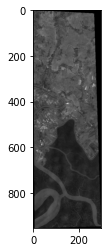

In [37]:
plt.imshow(erosion,cmap="gray")

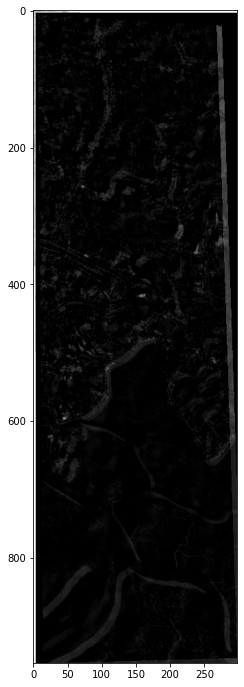

In [39]:
struc=np.zeros((8,8),np.uint8)
blackhat = cv.morphologyEx(pan_gray, cv.MORPH_BLACKHAT, struc)
fig = plt.figure(figsize=(20, 12))
fig.set_figheight(12)
fig.set_figwidth(20)
plt.imshow(blackhat,cmap="gray")


DWT on PAN

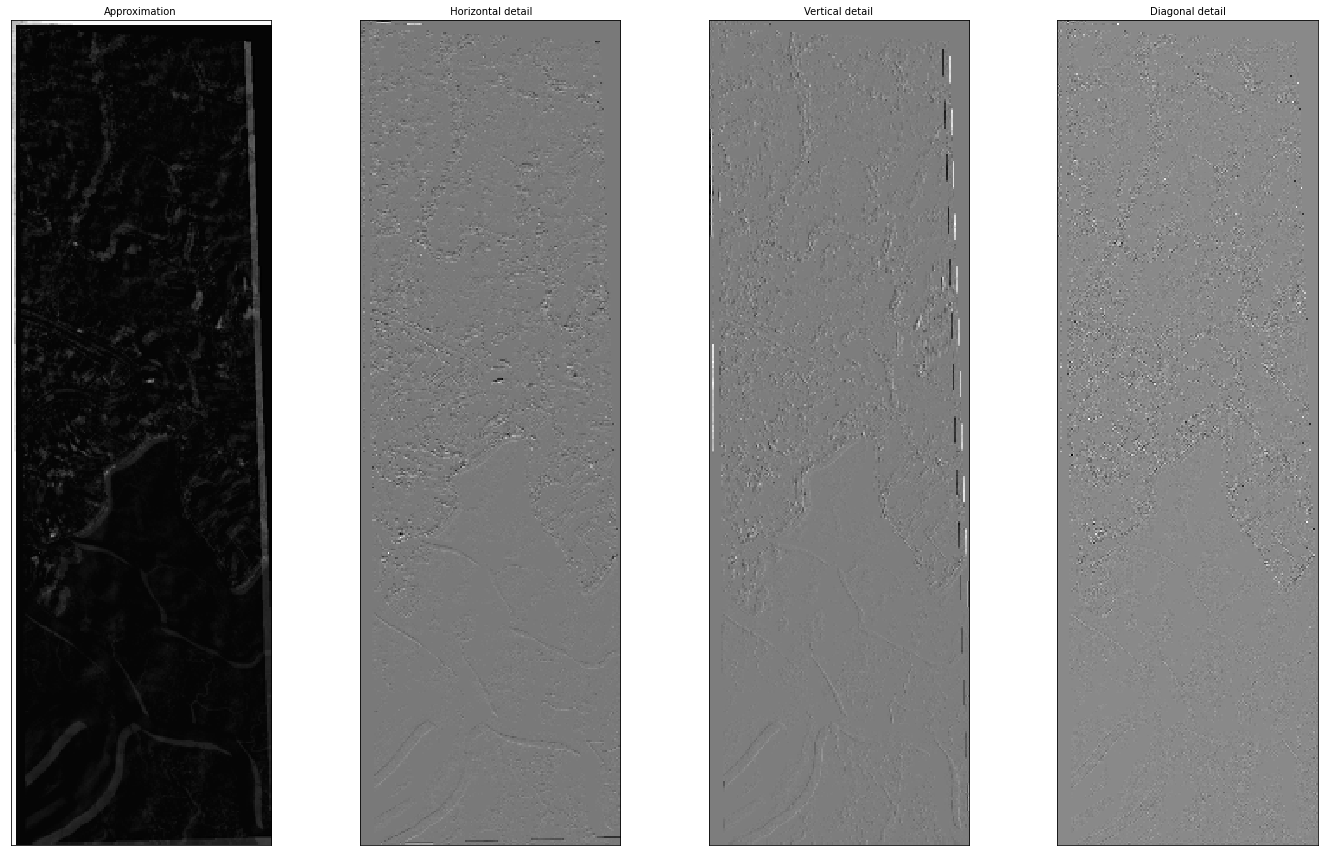

In [40]:
import pywt
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(blackhat, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(20, 12))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

DWT on PCA MS

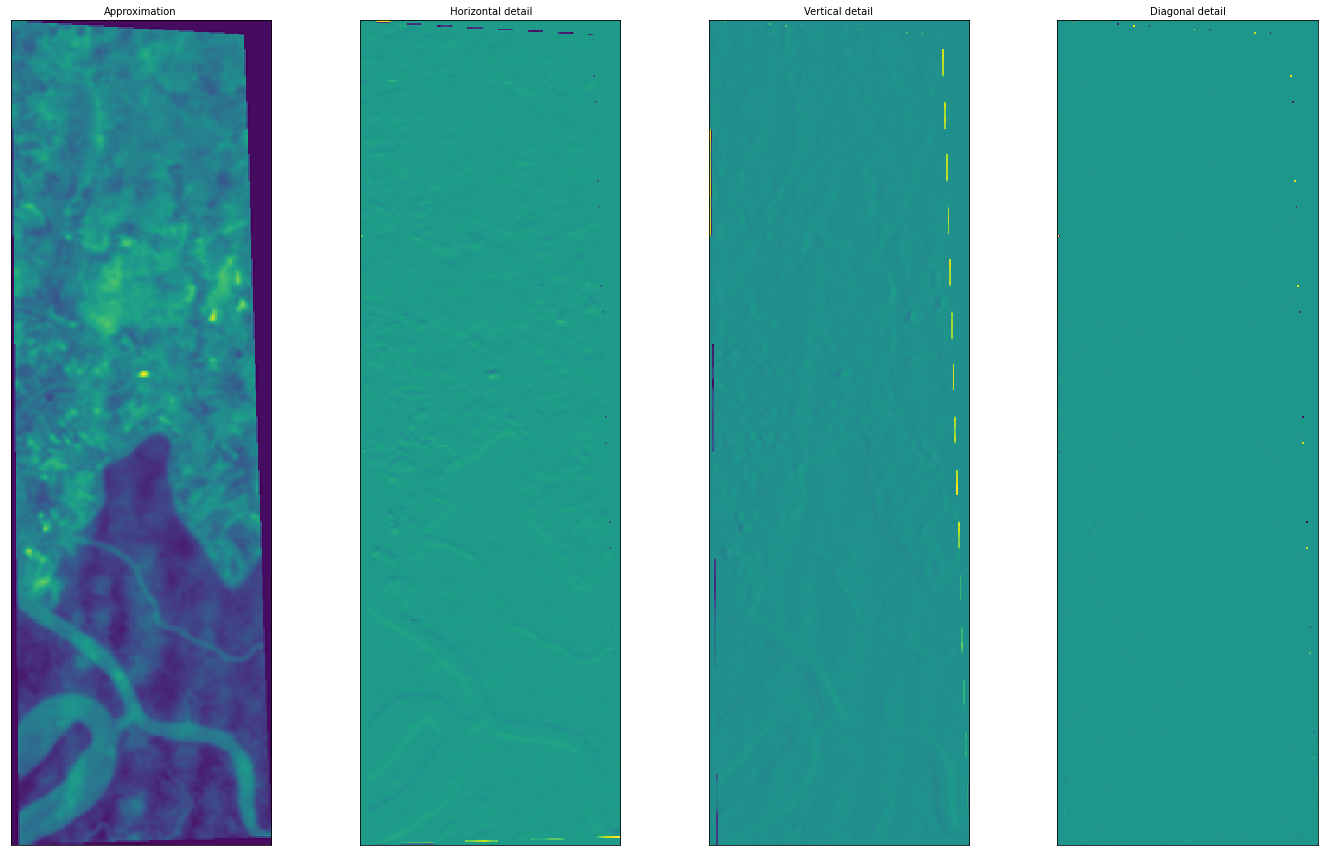

In [41]:
import pywt
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(arr_st[0], 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(20, 12))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest")
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Inverse PCA

In [42]:
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
transformer = IncrementalPCA(n_components=4, batch_size=800)
X_sparse = sparse.csr_matrix(X_scaled)
X_transformed = transformer.fit_transform(X_sparse)

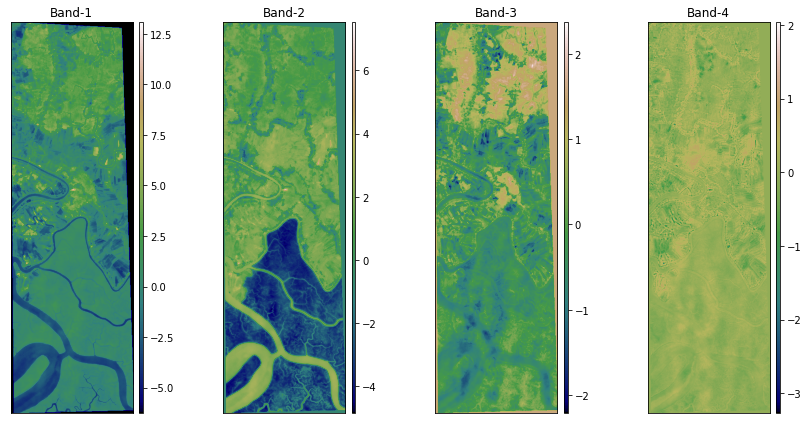

In [43]:
ep.plot_bands(np.moveaxis(X_transformed.reshape((954, 298, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 4,
              figsize = (12, 6),
              title = [f'Band-{i}' for i in range(1,5)])

plt.show()

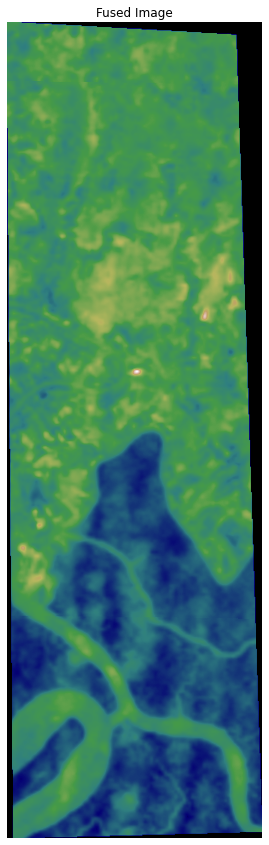

In [46]:
f, ax=plt.subplots()
f.set_figheight(15)
f.set_figwidth(18)
plt.imshow(arr_st[0], cmap= 'gist_earth')
ax.set_axis_off()
ax.set_title("Fused Image")
plt.show()

In [47]:
import skimage.measure  
import skimage.measure
entropy = skimage.measure.shannon_entropy(arr_st[0])
print(entropy)

9.410566579718573


In [48]:
import skimage.measure  
import skimage.measure
entropy = skimage.measure.shannon_entropy(arr_st)
print(entropy)

11.068134546866188


In [49]:
import skimage.measure  
import skimage.measure
entropy = skimage.measure.shannon_entropy(pan_stacks)
print(entropy)

11.027842138789719
